# Introducción

Cuando una sociedad se expone a una epidemía infecto contagiosa, además de las medidas oficiales para controlar su dispersión esta

In [1]:
from Simulacion2 import Simulacion
from Simulacion3 import SimulacionAgrupada
import math
import matplotlib.pyplot as plt
import numpy as np

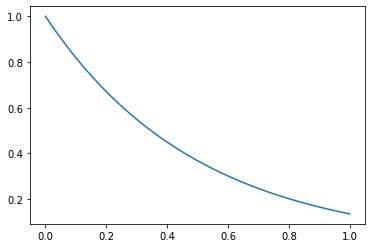

In [2]:
x = np.linspace(0, 1, 1000)
y = np.exp(-x*0.1) ** 20
plt.plot(x,y)
plt.show()

(array([822., 123.,  35.,  10.,   3.,   2.,   0.,   2.,   1.,   2.]),
 array([ 0.0529045 ,  2.50452305,  4.9561416 ,  7.40776015,  9.8593787 ,
        12.31099725, 14.7626158 , 17.21423434, 19.66585289, 22.11747144,
        24.56908999]),
 <BarContainer object of 10 artists>)

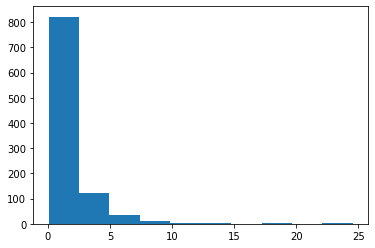

In [3]:
plt.hist(np.random.lognormal(0,1,1000))

# Primer paso: Escenario sin oscilaciones

Hay que ajustar el tamaño de la población para llegar a un escenario donde el modelo se estabilice a lo esperable analiticamente

Mayor ruido, se diferencian más del modelo continuo

Parametros fijos

In [20]:
M = 20   # Número de entidades
tiempo = 1000
til_base = 5
tic_base = 5
memoria = 0.5
umbral = 4
contagiosidad = 0.1
max_tolerancia_riesgo = 1e99 # anular el factor del miedo
expuestos_iniciales = 5

Parametro a modificar para llegar a la situación estable

N = 1000

In [21]:
def Probar_Escenario_N(N, ax1, ax2):
    simulacion = Simulacion(N, M, til_base, tic_base, memoria, max_tolerancia_riesgo, umbral, fun_contagio = lambda expuestos, asistencias: 1-math.exp(-contagiosidad * expuestos/(asistencias)), initial_exposeds = expuestos_iniciales)
    historial_infectados, historial_satisfaccion, historial_asistencias = simulacion.ejecutar_simulacion(tiempo)
    ax1.plot(historial_infectados, label='Infectados')
    ax1.plot(historial_satisfaccion, label='Satisfacción')
    asistencias_posibles = len(simulacion.asistencias_posibles())
    ax1.plot([x/asistencias_posibles * N for x in historial_asistencias], label='Asistencias')
    ax1.legend()

    m_infectados = max(historial_infectados)
    ax2.plot([x/m_infectados for x in historial_infectados], label = "Infectados reescalados (1 = maximo de infectados)")

    ax1.set_title(f"Simulación con {N} personas")
    ax2.set_title(f"Simulación con {N} personas")
    ax2.legend()

    ax1.set_xlabel("Tiempo")
    ax2.set_xlabel("Tiempo")

TypeError: __init__() got an unexpected keyword argument 'expuestos_iniciales'

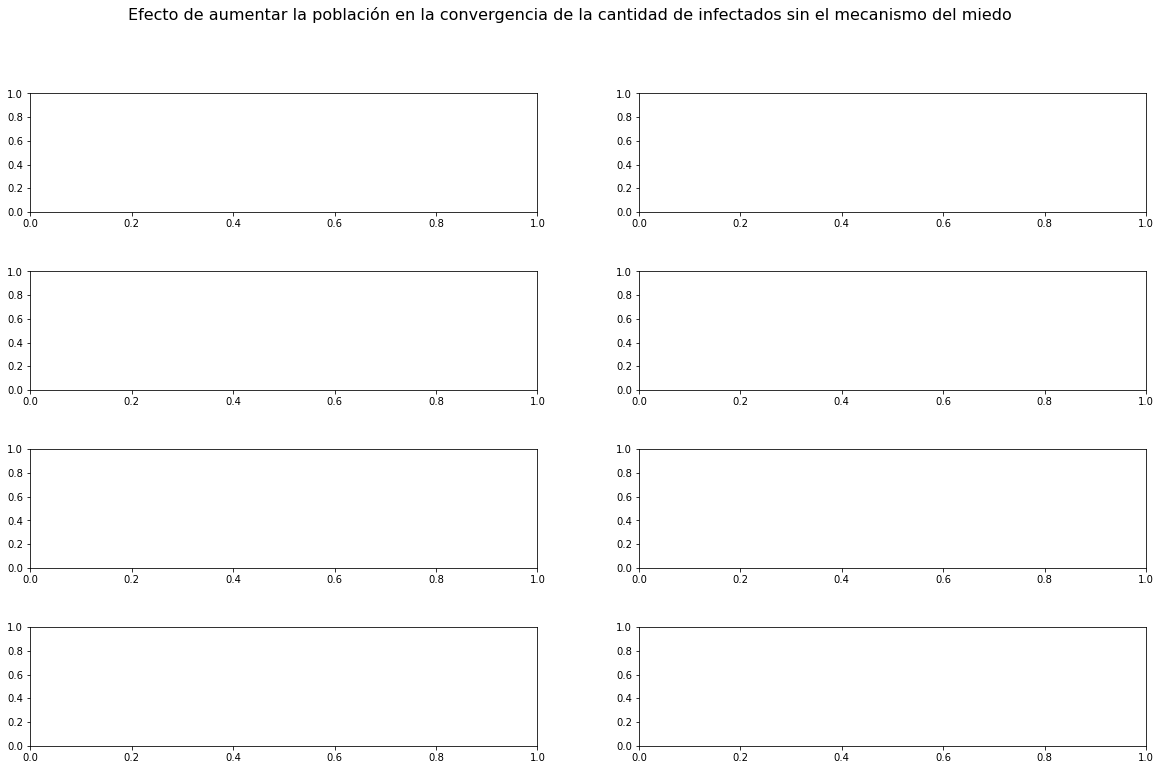

In [22]:
Ns = [100, 200, 500, 1000]#, 2000, 10000] #, 1000, 2000, 10000]
fig, ax = plt.subplots(nrows=len(Ns), ncols=2, figsize=(20, 3 * len(Ns)), gridspec_kw={'hspace': 0.5})
fig.suptitle('Efecto de aumentar la población en la convergencia de la cantidad de infectados sin el mecanismo del miedo', fontsize=16)
for i, N in enumerate(Ns):
    Probar_Escenario_N(N, ax[i][0], ax[i][1])

plt.show()

Vemos que al aumentar la población tiende al modelo ideal SEIS (para los parametros adecuados)

# Incorporamos el miedo

Parametros fijos

In [7]:
N = 1000
M = 20   # Número de entidades
tiempo = 1000
til_base = 5
tic_base = 5
memoria = 0.5
umbral = 1.5
contagiosidad = 0.1
expuestos_iniciales = 5

Parametro de interes

In [8]:
max_tolerancia_riesgo = 1e99

Función que corre un escenario

In [9]:
def Probar_Escenario_Riesgo(max_tolerancia_riesgo, ax1, ax2):
    simulacion = Simulacion(N, M, til_base, tic_base, memoria, max_tolerancia_riesgo, umbral, fun_contagio = lambda expuestos, asistencias: 1-math.exp(-contagiosidad * expuestos/(asistencias)))
    historial_infectados, historial_satisfaccion, historial_asistencias = simulacion.ejecutar_simulacion(tiempo)
    ax1.plot(historial_infectados, label='Infectados')
    ax1.plot(historial_satisfaccion, label='Satisfacción')
    asistencias_posibles = len(simulacion.asistencias_posibles())
    ax1.plot([x/asistencias_posibles * N for x in historial_asistencias], label='Asistencias')
    ax1.legend()

    m_infectados = max(historial_infectados)
    ax2.plot([x/m_infectados for x in historial_infectados], label = "Infectados reescalados (1 = maximo de infectados)")

    ax1.set_title(f"Simulación con {max_tolerancia_riesgo} tolerancia al riesgo")
    ax2.set_title(f"Simulación con {max_tolerancia_riesgo} tolerancia al riesgo")
    ax2.legend()

    ax1.set_xlabel("Tiempo")
    ax2.set_xlabel("Tiempo")


KeyboardInterrupt



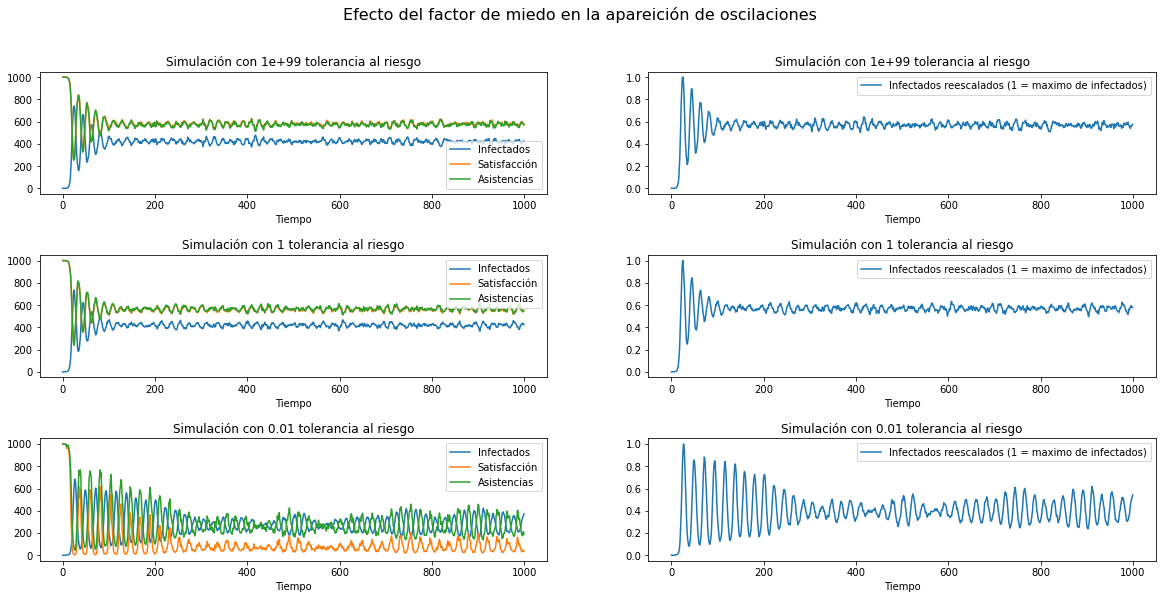

In [10]:
max_tolerancia_riesgos = [1e99, 1, 0.01, 0.001, 0.0005, 0.000375, 0.00025, 0.0001]
fig, ax = plt.subplots(nrows=len(Ns), ncols=2, figsize=(20, 3 * len(Ns)), gridspec_kw={'hspace': 0.5})
fig.suptitle('Efecto del factor de miedo en la apareición de oscilaciones', fontsize=16)
for i, max_tolerancia_riesgo in enumerate(max_tolerancia_riesgos):
    Probar_Escenario_Riesgo(max_tolerancia_riesgo, ax[i][0], ax[i][1])

plt.show()